Deep Lab V3 Pretrained Model

In [1]:
!pip install scikit-image

In [2]:

import torch
import os
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import SubsetRandomSampler
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from torch.utils.data import Dataset, DataLoader
import torchvision
import zipfile
import datetime

#### Checks if Files Loaded

In [3]:
# checks if the data is available

if not os.path.exists('./parsed'):
    zip_file_name = 'parsed.zip'

    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        # Extract all the contents of zip file in current directory
        zip_ref.extractall()

    print("Data is Loaded")
else:
    print("Data is Already Loaded")


Data is Already Loaded


Data Loader

In [4]:

img_dataset = "./parsed/images"
mask_dataset = "./parsed/masks"


WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
GREY = (127, 127, 127)

# Create train validation and test sets
class ImageDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.image_list = os.listdir(image_paths)
        self.mask_list = os.listdir(mask_paths)
        self.image_list.sort()
        self.mask_list.sort()
        self.mask_value = {
            WHITE: 0,
            BLACK: 1,
            GREY: 2
        }

    def __getitem__(self, index):

        img = io.imread(self.image_paths + "/" + self.image_list[index])
        mask = io.imread(self.mask_paths + "/" + self.mask_list[index])

        ## Convert Grey Scale to One Hot Encoding
        new_mask = np.zeros((mask.shape[0], mask.shape[1], 3))

        for idx in range(0,3):
            new_mask[:, :, idx] = np.isin(mask[:, :, 0], list(self.mask_value.keys())[idx]).astype(int)
            
        img = img.transpose(1,0,2)
        new_mask = new_mask.transpose(1,0,2)

        if self.transform is not None:
            img = self.transform(img)
            new_mask = self.transform(new_mask)

        return img, new_mask

    def __len__(self):
        return len(self.image_list)

#### Loss

In [5]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, output, target):
        output = torch.sigmoid(output)
        intersection = (output * target).sum()
        union = output.sum() + target.sum()
        dice = 2.0 * intersection / (union + self.eps)
        return 1.0 - dice

def class_iou(output, target, num_classes=3):
    ious = []
    smooth = 1e-6
    output = torch.sigmoid(output)
    output = output.argmax(dim=1)
    target = target.argmax(dim=1)
    for cls in range(num_classes):

        intersection = ((output == cls) & (target == cls)).sum().float()
        union = ((output == cls) | (target == cls)).sum().float()

        if union == 0:
            ious.append(float('nan'))  # If there is no ground truth, do not include in evaluation
        else:
            ious.append((intersection + smooth) / (union + smooth))

    # we want to focus on the flesh + tools (less so on the background)
    total = 0.4 * ious[0] + 0.2 * ious[1] + 0.4 * ious[2]   
    total = total/3
    return total

#### Load Data

In [6]:

from torchvision.transforms import Grayscale


# Split the dataset into train, validation and test sets
train_split = 0.7
val_split = 0.2
test_split = 0.1

# batch size
batch_size = 100

# num workers
num_workers = 0

# transforms
transform = transforms.Compose([
    transforms.ToTensor(),

    # resize to 127 x 127
    transforms.Resize((127, 127))
    
])

# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load the dataset
dataset = ImageDataset(img_dataset, mask_dataset, transform=transform)

print("Dataset Size: {}".format(len(dataset)))

# split the dataset into train, validation and test sets
train_size = int(train_split * len(dataset))
val_size = int(val_split * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# if GPU pin memory
pin_memory = True if device == 'cuda' else False

# create dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

# check the dataset
print("Train Dataset: {}".format(len(train_dataset)))
print("Validation Dataset: {}".format(len(val_dataset)))
print("Test Dataset: {}".format(len(test_dataset)))

# sanity check images via visualization
def visualize(data_loader):
    for batch_idx, (data, target) in enumerate(data_loader):

        data, target = data.to(device), target.to(device)

        for i in range(10):
            plt.subplot(1, 2, 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0))
            plt.title("Input Image")
            plt.subplot(1, 2, 2)
            plt.imshow(target[i].cpu().argmax(dim=0))
            plt.title("Ground Truth Mask")
            plt.show()
            
        break

def visualizeImage(num:int ):
    img_pat = "./parsed/images/img_"+ str(num) + ".png"
    mask_pat = "./parsed/masks/img_"+ str(num) + ".png"
    img = io.imread(img_pat)
    mask = io.imread(mask_pat)
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Input Image")
    plt.subplot(1, 2, 2)
    plt.imshow(mask)
    plt.title("Ground Truth Mask")
    plt.show()
    


# visualize(test_loader)
# plt.show()



Dataset Size: 8080
Train Dataset: 5656
Validation Dataset: 1616
Test Dataset: 808


#### Model

In [7]:
def getModel():
    model = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=False)

    # set output layer to just 3
    model.classifier[-1] = torch.nn.Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))

    return model


#### Utility Functions for Train and Test

In [8]:
def train(model,criterion,optimizer,accFunction,dataset,device,listLoss,listAcc):

    model.train()

    totalLoss = 0
    totalAcc = 0
    for batch_idx, (data, target) in enumerate(dataset):

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)['out']

        loss = criterion(output, target)

        loss.backward()
        optimizer.step()
        
        currLoss = loss.item()
        currAcc = accFunction(output,target)
        
        totalLoss += currLoss
        totalAcc += currAcc

        listLoss.append(currLoss)
        listAcc.append(currAcc)
        
        if batch_idx % 10 == 0:
            print("Batch: {} Loss: {} Acc: {}".format(batch_idx, loss.item(),currAcc))


    totalAcc /= len(dataset)
    totalLoss /= len(dataset)

    print("Loss: {} Accuracy: {}".format(totalLoss,totalAcc))

    return totalLoss,totalAcc.item()

def test(model,criterion,accFunction,dataset,device,listLoss,listAcc):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():

        acc = 0
        loss = 0
        for batch_idx, (data,target) in enumerate(dataset):
            data,target = data.to(device),target.to(device)
        
            output = model(data)['out']
                
            pred = output.argmax(dim=1,keepdim=True)

            currAcc = accFunction(output,target)
            currLoss = criterion(output,target)
            
            listLoss.append(currLoss)
            listAcc.append(currAcc)
            
            acc += currAcc
            loss += loss
            

    acc /= len(dataset)
    loss /= len(dataset)

    print("Loss: {} Accuracy: {}".format(loss,acc))

    return loss,acc.item()

#### Full Loop

In [9]:
num_epochs = 3
# learning rate
lr = 0.001

# criterion
criterion = DiceLoss()



def trainLoop(model,scheduler,optimizer,accFunction,times):
    # Hyper parameters
    # train the model
    trainLossList = []
    trainAccList = []
    validLossList = []
    validAccList = []
    torch.cuda.empty_cache()
    model = model.to(device)

    for epoch in range(num_epochs):
    
        print("Epoch " + str(epoch)+ " ---------------------------------------------")
        currTime = datetime.datetime.now()

        train(model, criterion, optimizer,accFunction, train_loader, device,trainLossList,trainAccList)
        test(model, criterion,accFunction, val_loader, device,validLossList,validAccList)
        scheduler.step()
        endTime = datetime.datetime.now() - currTime
        endTime = endTime.total_seconds() * 1000

        times.append(endTime)
        
        print("-----------------------------------------------------------------")
    return trainLossList,trainAccList,validLossList,validAccList


#### Plot

In [10]:
def plot(validLossList,validAccList,trainLossList,trainAccList, times):
        # convert to tensor
    validLossList = torch.tensor(validLossList)
    validAccList = torch.tensor(validAccList)
    trainLossList = torch.tensor(trainLossList)
    trainAccList = torch.tensor(trainAccList)

    # move to cpu
    validLossList = validLossList.cpu()
    validAccList = validAccList.cpu()
    trainLossList = trainLossList.cpu()
    trainAccList = validAccList.cpu()

    # convert back to list 
    validLossList = validLossList.tolist()
    validAccList = validAccList.tolist()

    # plot the loss and accuracy in 2 by 2 grid

    plt.subplot(2, 2, 1)
    plt.plot(trainLossList)
    plt.title("Training Loss")
    plt.xlabel("Batch")

    plt.subplot(2, 2, 2)
    plt.plot(trainAccList)
    plt.title("Training Accuracy")
    plt.xlabel("Batch")

    plt.subplot(2, 2, 3)
    plt.plot(validLossList)
    plt.title("Validation Loss")
    plt.xlabel("Batch")

    plt.subplot(2, 2, 4)
    plt.plot(validAccList)
    plt.title("Validation Accuracy")
    plt.xlabel("Batch")

    plt.tight_layout()
    plt.show()

    # plot times
    plt.plot(times)
    plt.title("Time")
    plt.xlabel("Batch")
    plt.ylabel("Time")
    plt.show()



#### Loop for Time Analysis

ROUND: 0


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /home/ec2-user/.cache/torch/hub/v0.10.0.zip
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ec2-user/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 258MB/s]


Epoch 0 ---------------------------------------------


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Batch: 0 Loss: 0.5739799457672737 Acc: 0.04906100034713745
Batch: 10 Loss: 0.20943871962633498 Acc: 0.2022373378276825
Batch: 20 Loss: 0.12896052109836265 Acc: 0.23944179713726044
Batch: 30 Loss: 0.09033184724492727 Acc: 0.2444218397140503
Batch: 40 Loss: 0.0637357215161154 Acc: 0.2552304267883301
Batch: 50 Loss: 0.060272823901478256 Acc: 0.26188158988952637
Loss: 0.14013348282902569 Accuracy: 0.22762688994407654
Loss: 0.0 Accuracy: 0.2683446407318115
-----------------------------------------------------------------
Epoch 1 ---------------------------------------------
Batch: 0 Loss: 0.05054358039708351 Acc: 0.2664557099342346
Batch: 10 Loss: 0.04391872490016524 Acc: 0.2728031277656555
Batch: 20 Loss: 0.04183657993689538 Acc: 0.2715604305267334
Batch: 30 Loss: 0.03926508080491686 Acc: 0.27853769063949585
Batch: 40 Loss: 0.03502928077123213 Acc: 0.27742472290992737
Batch: 50 Loss: 0.03924974975563289 Acc: 0.2767584025859833
Loss: 0.040995232937789734 Accuracy: 0.2760833203792572
Loss: 0

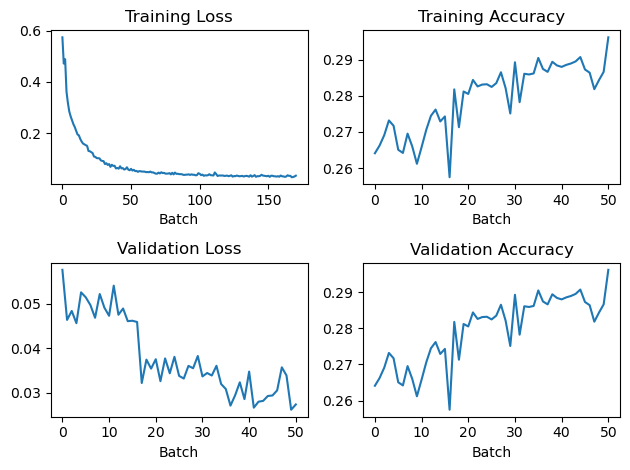

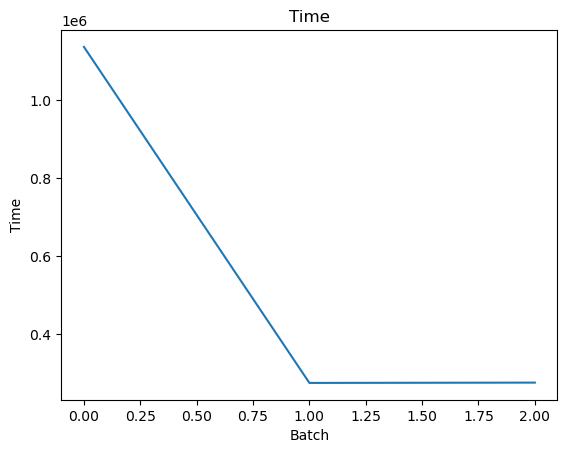

Total Time For Round: 0 is 275454.991ms


In [11]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
numTimes = 1 # set this to 1 if you want to run it once

totalTimes = []

for i in range(numTimes):
    print("ROUND: " + str(i))

    model = getModel() # Beware of ordering of lines, need to create new instance

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    trainLossList,trainAccList,validLossList,validAccList= trainLoop(model,scheduler,optimizer,class_iou,totalTimes)
        
    plot(validLossList,validAccList,trainLossList,trainAccList,totalTimes)

    print("Total Time For Round: " + str(i) + " is " + str(totalTimes[-1]) + "ms")

#### Stats

In [12]:

print(totalTimes)

# Average Time
print("Average Time (ms): {}".format(sum(totalTimes)/len(totalTimes)))

# Standard Deviation
print("Standard Deviation: {}".format(np.std(totalTimes)))

[1136208.2419999999, 274650.864, 275454.991]
Average Time (ms): 562104.6989999999
Standard Deviation: 405952.64109575027


#### Test Output

In [13]:
testLossList = []
testAccList = []


currTime = datetime.datetime.now()
test(model, criterion,class_iou, test_loader, device,testLossList,testAccList)
endTime  = datetime.datetime.now() - currTime


testLossList = torch.tensor(testLossList)
testAccList = torch.tensor(testAccList)

# move to cpu
testLossList = testLossList.cpu()
testAccList = testAccList.cpu()

# convert to numpy 
testLossList = np.array(testLossList)
testAccList = np.array(testAccList)

# Averages
print("Test Loss: {} Test Accuracy: {}".format(sum(testLossList)/len(testLossList),sum(testAccList)/len(testAccList)))

# Inference Time
endTime = endTime.total_seconds() * 1000
print("Inference Time: {}ms".format(endTime))

# Standard Deviation
print("Standard Deviation: {}".format(np.std(testLossList)))
print("Standard Deviation: {}".format(np.std(testAccList)))

Loss: 0.0 Accuracy: 0.286761075258255
Test Loss: 0.030203035262183976 Test Accuracy: 0.2867610735051772
Inference Time: 55551.346000000005ms
Standard Deviation: 0.0033949051474603032
Standard Deviation: 0.004717065952718258


#### Visualize Examples

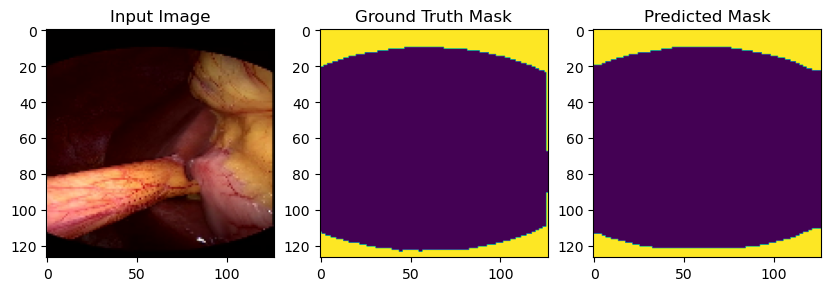

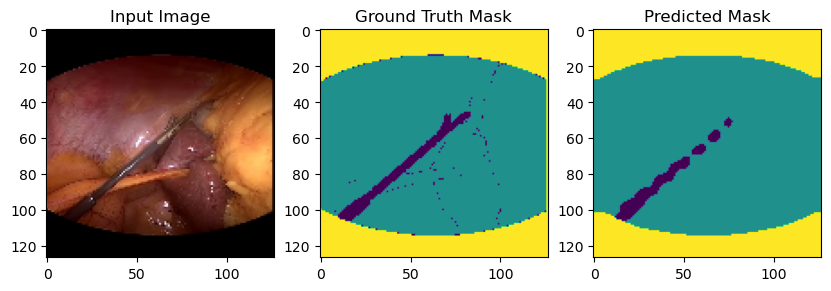

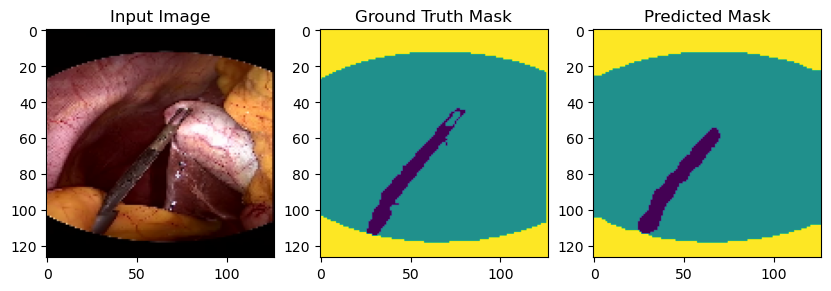

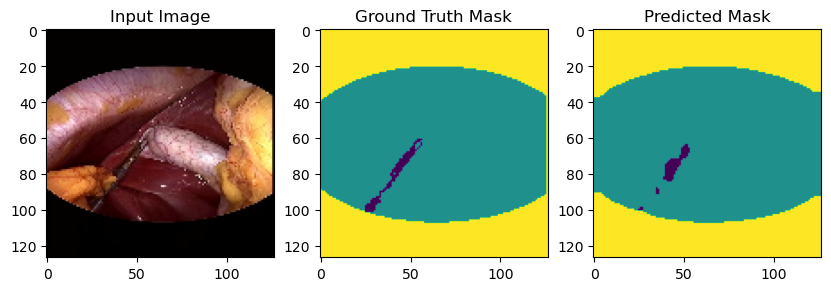

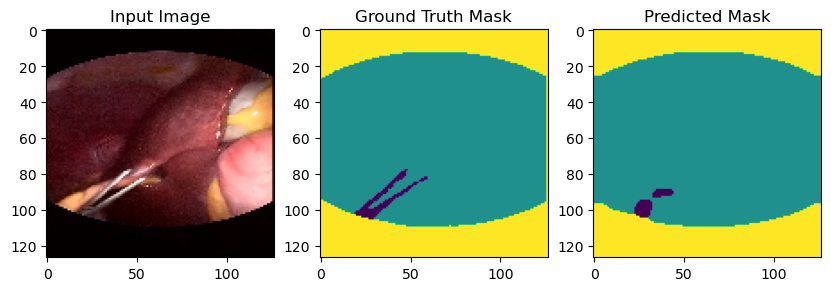

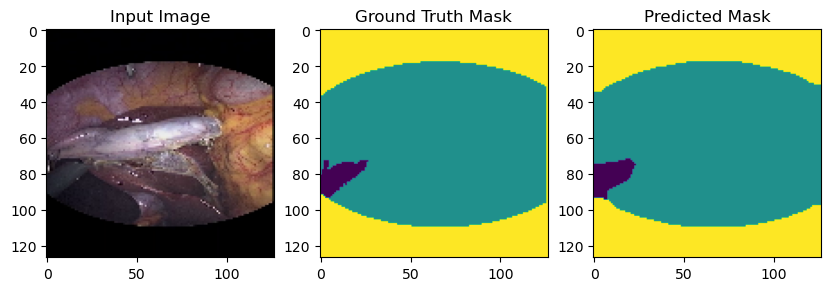

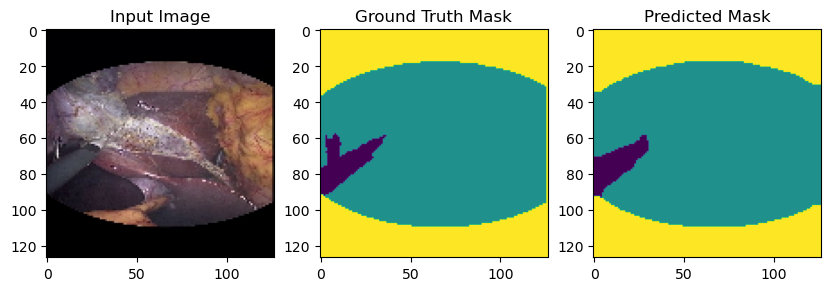

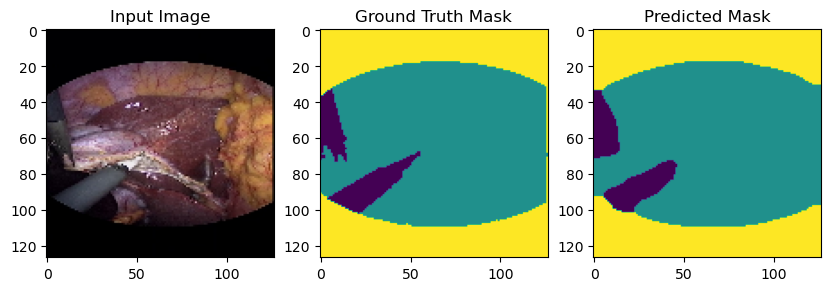

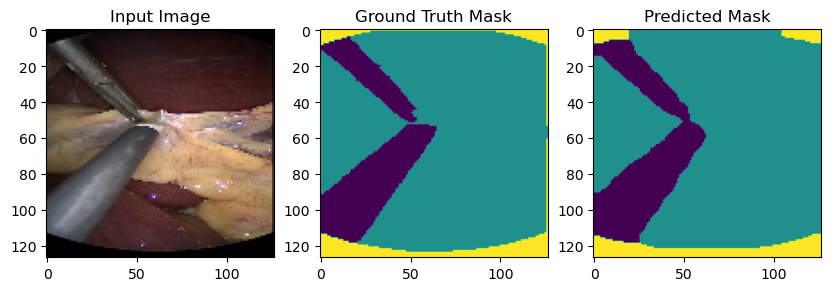

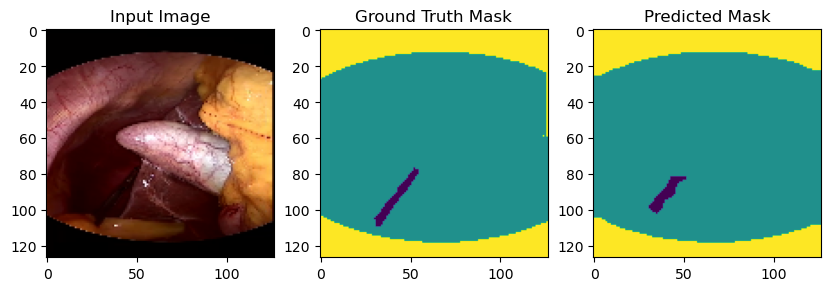

In [14]:
# visualize examples 10 

def visualize(data_loader):
    for batch_idx, (data, target) in enumerate(data_loader):

        data, target = data.to(device), target.to(device)

        for i in range(10):
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0))
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(target[i].cpu().argmax(dim=0))
            plt.title("Ground Truth Mask")
  
            plt.show()

        break

# visualize(test_loader)


model.eval()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(train_loader):

        data, target = data.to(device), target.to(device)

        output = model(data)['out']
        pred = output.argmax(dim=1, keepdim=True)

        for i in range(10):
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 3, 1)
            plt.imshow(data[i].cpu().permute(1, 2, 0))
            plt.title("Input Image")
            plt.subplot(1, 3, 2)
            plt.imshow(target[i].cpu().argmax(dim=0))
            plt.title("Ground Truth Mask")
            plt.subplot(1, 3, 3)
            plt.imshow(pred[i].cpu().squeeze())
            plt.title("Predicted Mask")
            plt.show()

        break


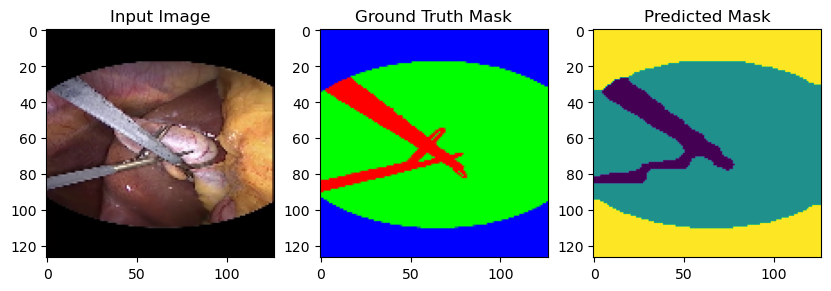

In [33]:

img_dataset = "./set_data/groundTruth"
mask_dataset = "./set_data/mask"

# create a data loader with just one image
image_dataset = ImageDataset(img_dataset, mask_dataset, transform=transform)

# create a data loader with just one image
image_loader = DataLoader(image_dataset, batch_size=1, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)


# get the image and mask
image, ground_truth = next(iter(image_loader))

# permute
ground_truth = ground_truth.squeeze()
ground_truth = ground_truth.permute(1, 2, 0)

# model inference
model.eval()

# move to device
image = image.to(device)

# get predictions
with torch.no_grad():
    output = model(image)['out']

# display actual, ground turth and predicted mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(image.cpu().squeeze().permute(1, 2, 0))
plt.title("Input Image")
plt.subplot(1, 3, 2)
plt.imshow(ground_truth)
plt.title("Ground Truth Mask")
plt.subplot(1, 3, 3)
plt.imshow(output.cpu().squeeze().argmax(dim=0))
plt.title("Predicted Mask")
plt.show()


In [ ]:
# save the model 
torch.save(model.state_dict(), 'deeplabv3_resnet50.pth')

